In [1]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

## YARN Cluster

- YARN: Running on a YARN Cluster

- If you only want to run Spark by itself on a set of machines, the built-in Standalone mode is the easiest way to deploy it. 

- However, if you have a cluster that you’d like to **share** with other distributed applications (e.g., both Spark jobs and Hadoop MapReduce jobs), Spark can also run over two popular cluster managers: Hadoop YARN and Apache Mesos


- Hadoop’s resource manger and execution system. 
    - Most Hadoop installations have YARN configured alongside HDFS.
    - Many organizations already have YARN clusters of a significant size, along with the technical know-how, tools, and procedures for managing and monitoring them.
 
 
- You don’t have to install Spark on all nodes in the cluster.
    - When you submit Spark application ==> it will create it (or what???)
    - If you have to use Hadoop, or some other different schedulers --> YARN is the options as a cluster manager
    
    
- YARN lets you run different types of Java applications, not just Spark, so you can mix legacy Hadoop and Spark applications with ease.

- YARN provides methods for isolating and prioritizing applications among users and organizations, functionality the standalone cluster doesn’t have.

- It’s the only cluster type that supports Kerberos-secured HDFS (Secure HDFS mode) and authorizes access to resources to certain users using Kerberos-provided identity and access control lists in the Hadoop configuration.

Big Picture: Client -> Driver -> Executor -> Driver -> Client

## YARN Architecture

Unlike running on Spark’s standalone cluster, applications on YARN run in **containers**.  
Container - JVM process to which CPU and memory resource are granted.  

Cluster Components: 

1. **Resource Manager**: Similar to Spark’s master process. Allocate an application master via a node manager when an application is submitted.
2. **Node Manager**: Similar to Spark’s worker process. Launch executor containers.
3. **Application Master**: Similar to cluster manager. Responsible for negotiating resources with resource manager and launches and monitors containers with executors.

### Yarn Client Mode

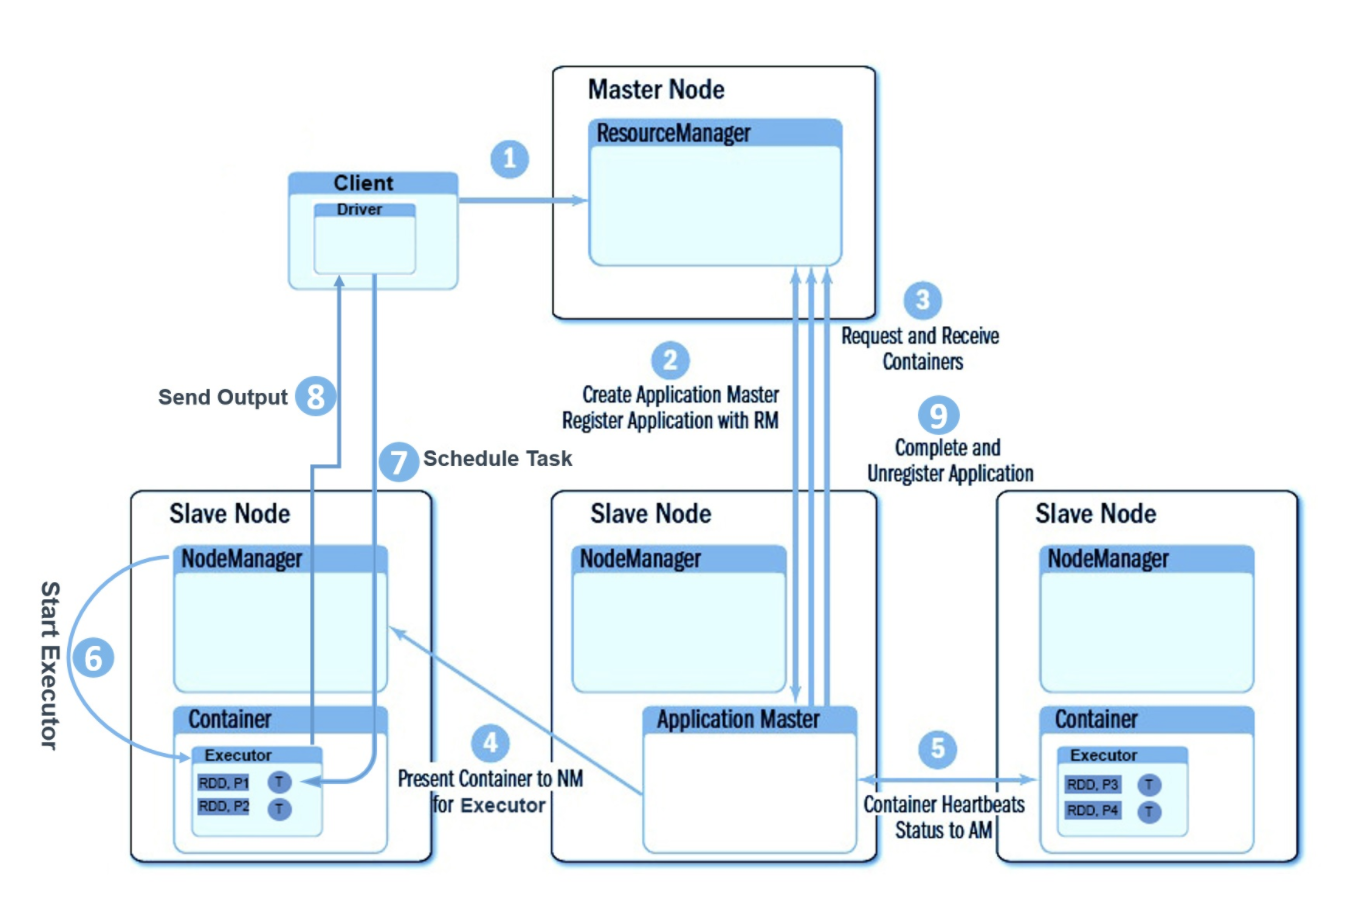

In [8]:
from IPython.display import Image
Image("/Users/ThyKhueLy/Downloads/spark-yarn-client-architect.png")

1. In Yarn Client mode: Driver run on client system that may be your laptop or any machine. Here there is **no Spark Master and no Worker Node**. Client send job to Applications manager running on master node.

2. Applications Manager request to Resource Manager for resource to run Application Master.

3. As Application Manager gets resource on one of Slave Nodes then create container and run Application Master or App master.

4. Once Application Master start running driver connect to Application master and request for N no of executors. Application Master again connect to Resource Manager and request for container to run Executors. Here Resource Manager is doing job of spark master in Standalone mode.

5. Once it get information about nodes that have resource to create container. It connect to those node managers and request to create container.

6. Node Manager create container to run Executors. Once container is ready application master run Executor in it.

7. Once executors start running driver schedule tasks in multiple slot for each executors.

8. Once all tasks completed it send output to driver.

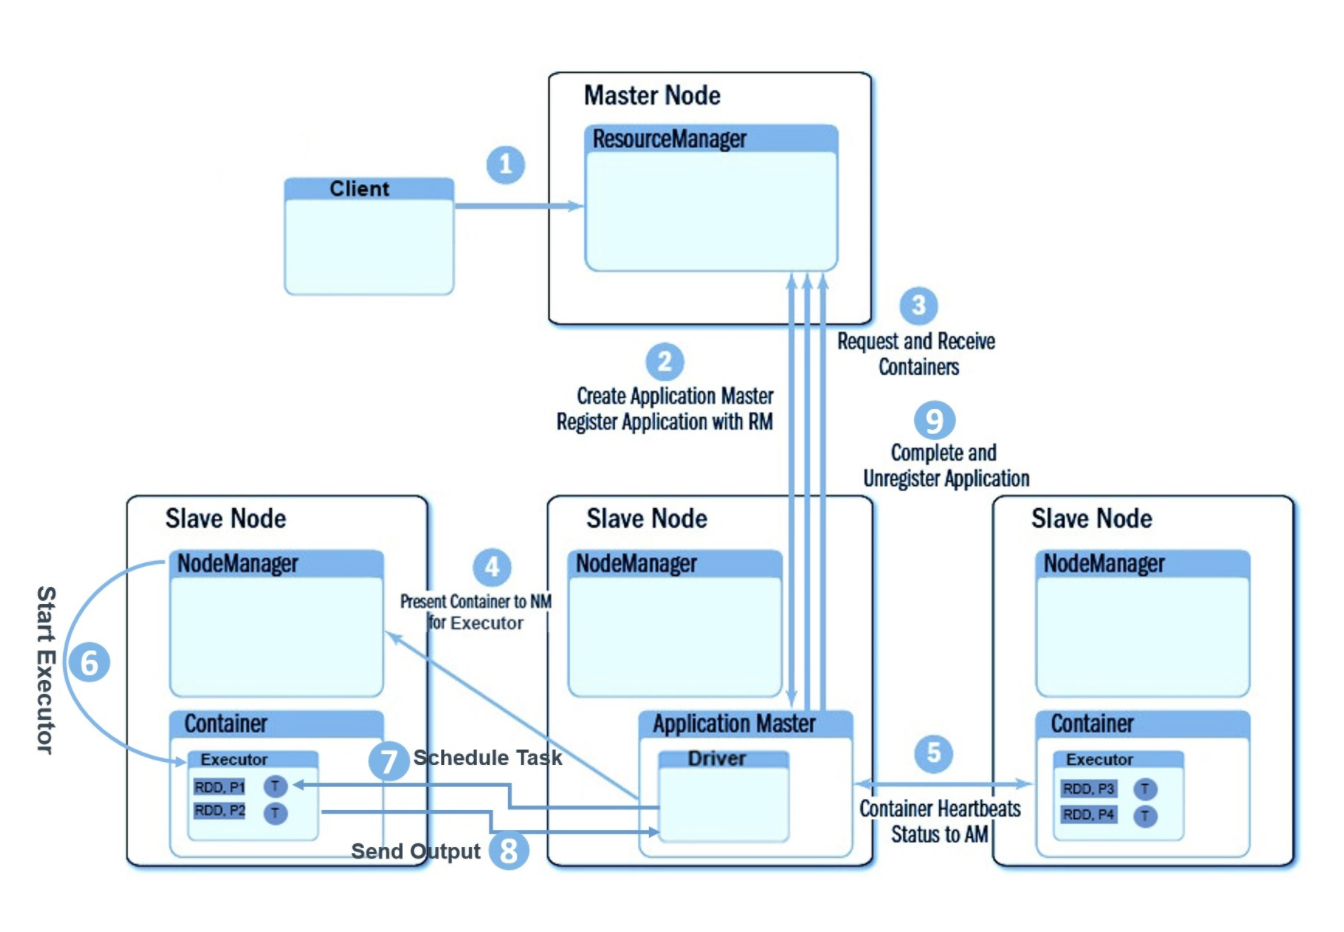

In [5]:
from IPython.display import Image
Image("/Users/ThyKhueLy/Downloads/spark-yarn-cluster-architect.png")

## Mesos Cluster

- The Spark project was originally started in order to demonstrate the usefulness of Mesos.
- Provides fine-grained/coarse-grained resource sharing.
- Support applications written in Java, C, C++, and Python.
- Run Docker containers
- Docker containers wrap a piece of software in a complete filesystem that contains everything needed to run: code, runtime, system tools, system libraries – anything that can be installed on a server. This guarantees that the software will always run the same, regardless of its environment.
- With Docker support, you can run Mesos on any applications that can run in a Docker Container.
- Example applications running on Mesos – Apple Siri, eBay, Netflix, Twitter, Uber, etc.

## Loading & Saving Data

Spark supports **unstructured/semi-structured/structured** types of data. File Formats include the followings (and many more)

|Format | Structured | Comments
|:-------|:----------:|:---------
|Text File | No |  One line is one element for a single file.
|JSON |  Semi | Most libraries require one record per line.
|CSV/TSV | Yes | Contains fixed number of fields per line.
| Sequence File | Yes | Hadoop file format used for key-value data.
| Object File | Yes | Used for saving data from a Spark job to be consumed by shared code.

### Text Format
   - Load
       - **`textFile(file_name)`**: creates a RDD with each line as an element,  one line is one element in a single file.
       - **`wholeTextFiles(dir_name)`**: Can load multiple text files as pair RDDs, with the key being the file name and the value being the file content.
       - Useful when each file represent a certain time period’s
        data and need to use it for statistics. Ex. sales stat.
   - Save
       - Use `saveAsTextFile(new_subdir_name)` method.
       - Return multiple output files underneath the new_subdir_name, as Spark writes the output from multiple partitions.

### Example 1
Load all the .csv files under a directory as Pair RDDs with key being a file name and values being the content of the file.

In [12]:
files = sc.wholeTextFiles("./data")

In [13]:
for f in files.take(1): 
    print f

(u'file:/Users/ThyKhueLy/msan694/inclass/data/ignatian_pedagogy.txt', u'= Ignatian Values =\nThe University of San Francisco enjoys a distinguished heritage and Jesuit tradition.  At the core of this tradition are transcendent values, including the integration of learning, faith and service; care for the whole person; character and conviction; religious truth and interfaith understanding; and a commitment to building a more just world.  The key values of this Jesuit tradition are as follows:\n***********************************************************************************\n1. Contemplative in Action - St. Ignatius Loyola believed that prayer and reflectivity should so guide our choices and actions that our activity itself becomes a way of entering into union with and praising God.  Being a contemplative in action also means seeing beyond the superficial in life to appreciate the mystery, beauty, and sacredness of all life.  It is a means of seeing God in all things and in everyone. 

In [14]:
files.keys().collect()

[u'file:/Users/ThyKhueLy/msan694/inclass/data/ignatian_pedagogy.txt',
 u'file:/Users/ThyKhueLy/msan694/inclass/data/README.md',
 u'file:/Users/ThyKhueLy/msan694/inclass/data/supervisor_sf.csv']

### Example 2
From "supervisor_sf.csv”, filter data including “94103” and save under ”supervisor_94103”.
Todo : Change the number of partitions, and see the output.

In [29]:
sup_raw = sc.textFile("./data/supervisor_sf.csv")

In [30]:
sup = sup_raw.flatMap(lambda l: l.split("\n")).distinct().map(lambda x: x.split(","))

In [31]:
filtered = sup.filter(lambda x: "94103" in x)

In [34]:
filtered.saveAsTextFile("supervisor_94103")

### JSON File

- Use python’s json package.
- Load
- Use j`son.loads()` method.
    ```
    import json
    data = input.map(lamdbda x: json.loads(x))
    ```
- Load one JSON record per row. 
- Use SparkSQL (Intersession).
- Save: Use json.dumps() and then saveAsTextFile()
    ```
    json_output = data.map(lamdbda x: json.dumps(x))
    ```

### Example 3 
- Load ”example.json”.
- Filter item that has 3 in “array”.
- Convert the filtered output in JSON format and save in “json_data_with_3” folder.

In [36]:
import json

In [45]:
input = sc.textFile("./data/example.json")
json_input = input.map(lambda x: json.loads(x))

In [46]:
json_input.collect()

[{u'ID': u'id_1', u'array': [1, 2, 3], u'dict': {u'key': u'value1'}},
 {u'ID': u'id_2', u'array': [2, 4, 6], u'dict': {u'key': u'value2'}},
 {u'ID': u'id_3',
  u'array': [3, 6, 9],
  u'dict': {u'extra_key': u'extra_value3', u'key': u'value3'}}]

In [52]:
filtered = json_input.filter(lambda x: 3 in x['array'])

In [53]:
filtered.collect()

[{u'ID': u'id_1', u'array': [1, 2, 3], u'dict': {u'key': u'value1'}},
 {u'ID': u'id_3',
  u'array': [3, 6, 9],
  u'dict': {u'extra_key': u'extra_value3', u'key': u'value3'}}]

In [54]:
json_output = filtered.map(lambda x: json.dumps(x))

In [56]:
json_output.saveAsTextFile("json_data_with_3")

### CSV / TSV Format

Comma Separated Value (CSV) and Tab separated Value (TSV)
- Use python’s csv package. 
- Load
    - Use **textFile()**/ **wholeTextFiles()** and parse the csv to load the data.
    - And use **StringIO.StringIO()** to read a string buffer 
    - And **csv.DictReader(input, fieldnames)** to read information into a dict whose keys are given by the optional fieldnames parameter.
- Save
    - Write a function to write each row using **stringIO(), DictWriter(), WriteRow()**, etc.
    - Save the file using **saveAsTextFile()**.

### Example 4 
Read data from supervisor_sf.csv as a dictionary structure of (Zip, Supervisor). Choose Zip starting with “94”.

In [70]:
import csv
import StringIO

In [62]:
sup_raw = sc.textFile("./data/supervisor_sf.csv")
#sup = sup_raw.flatMap(lambda l: l.split("\n")).distinct().map(lambda x: x.split(","))

In [63]:
def csvLoader(line):
    input = StringIO.StringIO(line)
    reader = csv.DictReader(input, fieldnames=['Zip', 'Supervisor'])
    return reader.next()

In [71]:
csv_data = sup_raw.map(csvLoader)

In [75]:
csv_data.collect()[:10]

[{'Supervisor': '8', 'Zip': '94102'},
 {'Supervisor': '6', 'Zip': '94102'},
 {'Supervisor': '3', 'Zip': '94102'},
 {'Supervisor': '5', 'Zip': '94102'},
 {'Supervisor': '8', 'Zip': '94103'},
 {'Supervisor': '9', 'Zip': '94103'},
 {'Supervisor': '10', 'Zip': '94103'},
 {'Supervisor': '6', 'Zip': '94103'},
 {'Supervisor': '3', 'Zip': '94103'},
 {'Supervisor': '5', 'Zip': '94103'}]

In [73]:
sf_supervisor = csv_data.filter(lambda x: (x['Zip'].startswith('94')))

In [77]:
sf_supervisor.collect()[:10]

[{'Supervisor': '8', 'Zip': '94102'},
 {'Supervisor': '6', 'Zip': '94102'},
 {'Supervisor': '3', 'Zip': '94102'},
 {'Supervisor': '5', 'Zip': '94102'},
 {'Supervisor': '8', 'Zip': '94103'},
 {'Supervisor': '9', 'Zip': '94103'},
 {'Supervisor': '10', 'Zip': '94103'},
 {'Supervisor': '6', 'Zip': '94103'},
 {'Supervisor': '3', 'Zip': '94103'},
 {'Supervisor': '5', 'Zip': '94103'}]